In [16]:
#!/usr/bin/python3
# -*- coding: utf-8 -*-

import time
import os, sys
import re
import glob
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image as Image
from skimage import color
from skimage import io

from fun_map import *
from fun_gui import *
import ipywidgets as widgets
%matplotlib inline

########## Input 
feature_args = {'filename'  : 'large_G1_15mgml_x*5.00s', # [*] Specify
                'feature_id': 1,  # [*] Specify
                'log10'  : 1,
                'verbose': 0,
               } 

feature_1_args = {'source_dir' : '../thumbnails2/',
             'ext' : '.jpg',
             'pixels' : [[89, 122], [102, 201], [152, 73]],  # [*] Choose pixels
             #'pixels' : [[186, 111], [191, 115]],  # [*] Choose pixels
             'pixels_stat' : 2,     # [*] 'mean', 'max', 'var', or idx
             }

feature_2_args = {'source_dir' : '../circular_average/',
             'ext' : '.dat',
             'data_col' : [0, 2],
             'q_targets' : [0.0275], #0.053  # [*] Choose q0 or q0,q1
             'n' : 5     # [*] Choose the half-width (data points) of the peak q
             }

feature_3_args = {'source_dir' : '../linecut_angle/',
             'ext' : '.dat',
             'data_col' : [0, 1],
             'angle_targets': [20] # 'max' or specify angle 
             }
    
feature_args.update(feature_1_args=feature_1_args, feature_2_args=feature_2_args, feature_3_args=feature_3_args)

## Find matching files
infiles, match_re = get_filematch(feature_args)  


In [17]:
#### bqplot.heatmap
from bqplot import *
import bqplot.pyplot as bplt
from skimage import color
from fun_gui import *

def handle_slider_change(change):
    map1.color = color.rgb2gray(io.imread(infiles[change.new]))
    fig.title = infiles[change.new]
    
value_init = 0;
img = color.rgb2gray(io.imread(infiles[value_init])); m, n = img.shape              
x_sc, y_sc, c_sc, ax_x, ax_y, ax_c = bqplot_ax()
map1 = bplt.heatmap(img, x=np.arange(1,m,1), y=np.arange(1,n,1), scales={'x': x_sc, 'y': y_sc, 'color': c_sc})

fig = Figure(marks=[map1], animation_duration=100, axes=[ax_x,ax_y,ax_c])
fig.title = infiles[value_init]
fig.max_aspect_ratio = 1

scan_slider = widgets.IntSlider(min=0, max=100, step=1, description='Scan', value=value_init)
scan_slider.observe(handle_slider_change, 'value')

play_button = widgets.Play(min=0, max=100, interval=500)
widgets.jslink((play_button, 'value'), (scan_slider, 'value'))
widgets.VBox([widgets.HBox([play_button, scan_slider]), fig])


<IPython.core.display.Javascript object>


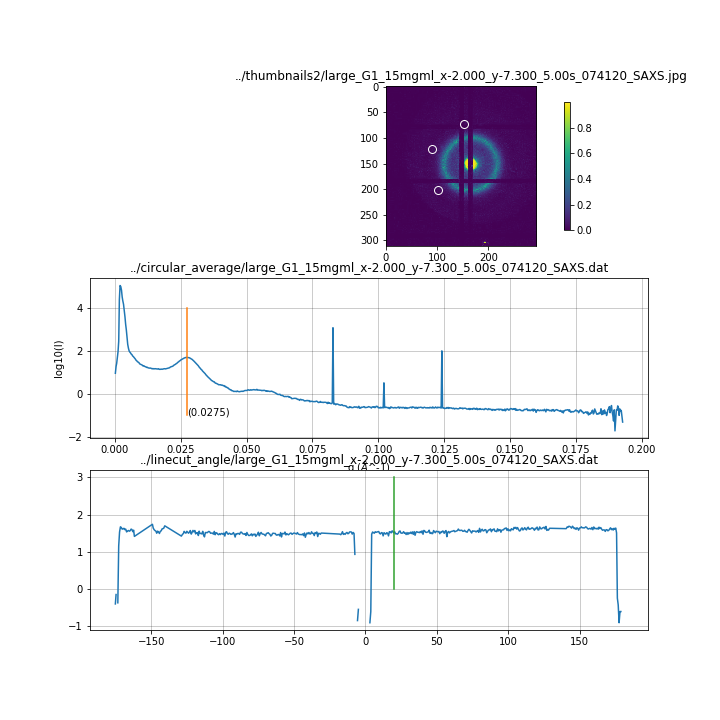

interactive(children=(IntSlider(value=344, description='scan', max=689), Output()), _dom_classes=('widget-inte…

In [14]:
def slider_data(scan):      
    ## Plot one data 
    fdim = [3, 1]
    cmap = plt.get_cmap('magma');  feature_args.update(cmap=cmap)
    feature_args.update(val_stat = [0, 1])
    
    ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=1); ax1.cla()     
    feature_args.update(feature_id=1); 
    plot_data(infiles1[scan], feature_args)  
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (1, 0), colspan=1); ax2.cla()
    feature_args.update(feature_id=2); 
    plot_data(infiles2[scan], feature_args)
        
    ax3 = plt.subplot2grid((fdim[0], fdim[1]), (2, 0), colspan=1); ax3.cla()
    feature_args.update(feature_id=3); 
    plot_data(infiles3[scan], feature_args)
    plt.show() 

idx = 1
feature_args.update(feature_id=idx); 
infiles1, match_re = get_filematch(feature_args)  

idx = 2
feature_args.update(feature_id=idx); 
infiles2, match_re = get_filematch(feature_args)  

idx = 3
feature_args.update(feature_id=idx); 
infiles3, match_re = get_filematch(feature_args)  


fig = plt.figure(100, figsize=[10,10]); plt.clf()
widgets.interactive(slider_data, scan=(0,len(infiles)-1))
#slider_data(3)


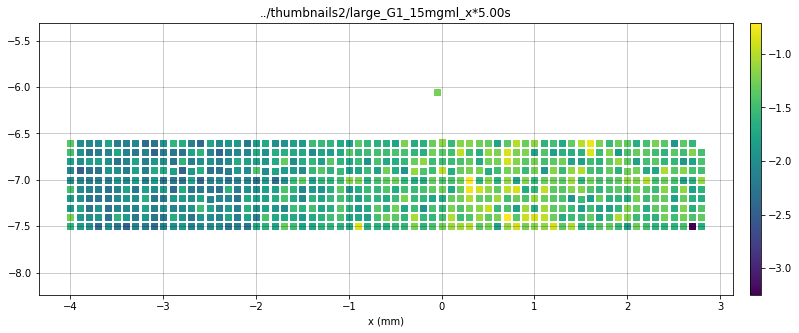

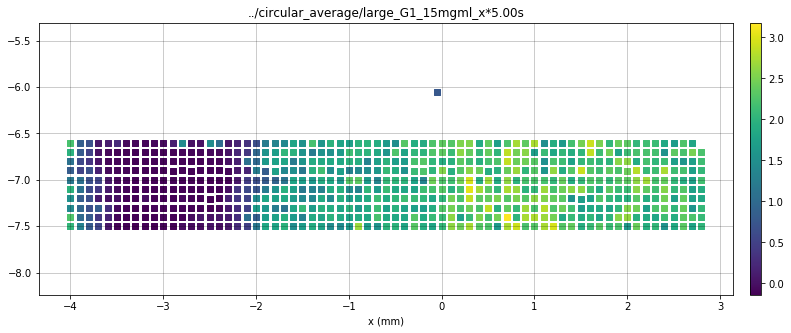

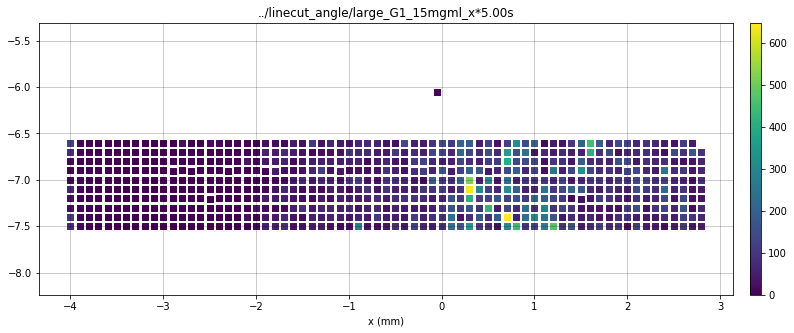

In [4]:
########## Feature map
feature_show = [1, 2, 3]
for idx in feature_show:
    feature_args.update(feature_id=idx); 
    
    ## Find matching files
    infiles, match_re = get_filematch(feature_args)  
    
    ## Get map
    scans, x_pos, y_pos, feature = get_map(infiles, match_re, feature_args) 
    feature_args.update(val_stat=[np.min(feature), np.max(feature)])
    
    ## Plot map
    fig = plt.figure(100+feature_args['feature_id'], figsize=[15,5]); plt.clf()
    cmap = plt.get_cmap('viridis');    feature_args.update(cmap=cmap)
    #feature_args.update(val_stat = [0, 20])
    plot_map(x_pos, y_pos, feature, feature_args)


<IPython.core.display.Javascript object>


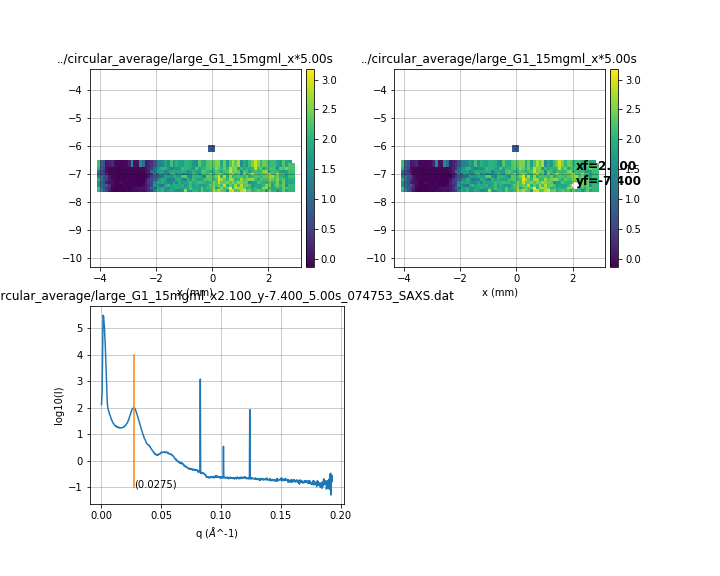

In [30]:
##### Click on map to show data
%matplotlib nbagg

fig = plt.figure(10, figsize=[10,8])
fdim = [2, 2]
axis_font = {'fontname':'Arial', 'size':'12', 'weight':'bold'}

ax1 = plt.subplot2grid((fdim[0], fdim[1]), (0, 0), colspan=1); ax1.cla()
feature_args.update(feature_id=2); 
infiles, match_re = get_filematch(feature_args) 
scans, x_pos, y_pos, feature = get_map(infiles, match_re, feature_args) 
plot_map(x_pos, y_pos, feature, feature_args)

pos = []
def onclick(event):   
    pos.append([event.xdata,event.ydata])
    xc = event.xdata
    yc = event.ydata 
    xf = x_pos[get_idx_q(x_pos, xc)]
    yf = y_pos[get_idx_q(y_pos, yc)]
    
    ax2 = plt.subplot2grid((fdim[0], fdim[1]), (0, 1), colspan=1); #ax2.cla()
    plot_map(x_pos, y_pos, feature, feature_args)
    plt.scatter(xc,yc,color='r')
    plt.scatter(xf,yf,color='w')
    ax2.set_aspect('equal')
    #ax2.text(xc,yc,'xc={:.3f}, yc={:.3f}'.format(xc, yc), **axis_font)
    ax2.text(xf,yf,'xf={:.3f}\nyf={:.3f}'.format(xf, yf), **axis_font)
    
    infiles = find_file(xf,yf, feature_args)
    ax3 = plt.subplot2grid((fdim[0], fdim[1]), (1, 0), colspan=1); #ax3.cla()
    plot_data(infiles[0], feature_args)
    ax3.title(infiles[0])
    
    #infiles = find_file(xf,yf, feature_args)
    ax4 = plt.subplot2grid((fdim[0], fdim[1]), (1, 1), colspan=1); #ax3.cla()
    plot_data(infiles[0], feature_args)
    ax4.title(infiles[0])

fig.canvas.mpl_connect('button_press_event', onclick)
fig.show()
